In [1]:
# Might need to pip install json, json_stream, as they are not default libraries
import json
import json_stream
import numpy as np
import os

from MODSIM import perform_one_time_step_poseData, create_and_place_simple_legacy_camera
from datatypes.vessel import Vessel
from dynamicSceneGenerator import DynamicSceneGenerator
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera
from visualize import visualize_projections_json_mov, visualize_bounding_boxes_json_mov, visualize_camera_pose_in_dsg_mov, visualize_dynamic_scene_mov, visualize_distorted_bounding_boxes_json_mov


# Initialize MODSIM

In [2]:
vehicle_characteristics_path = 'boats_in_fishtank/vehicle_characteristics.json'
dynamics_path = 'boats_in_fishtank/dynamics.json'
simulation_folder = './boats_in_fishtank/simulation/'

In [3]:
ERROR_CONFIG_PATH = 'detector_stats_config.yaml'
WRITE_TO_JSON = True
VISUALIZE=True

In [4]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'

CAMERA_TYPE = DYNAMIC

### Error generator

In [5]:
## Error generator
errorGenerator = ErrorGenerator(ERROR_CONFIG_PATH)

### DSG

In [6]:
# Get vessels
with open(vehicle_characteristics_path, 'r') as f:
    vessel_dict = json.load(f)

# air_draft: int = 2, beam: int = 2, length: int = 4, label: str = "")
vessels = [Vessel(vesselID, length=vessel['length_m'], beam=vessel['width_m'], label=vessel['type']) for vesselID, vessel in vessel_dict.items()]

In [7]:
# Create dynamic scene with vessels
dsg = DynamicSceneGenerator(vessels)

In [8]:
vessel_dict = {vessel.id: vessel for vessel in dsg.get_vessels()}

### Camera

In [9]:
if CAMERA_TYPE == DYNAMIC:
    ###### Dynamic Camera ######
    focal_length = 50*10**-3
    image_bounds = (3600, 2400) # Pixels (x,y)
    film_size = (36*10**-3, 24*10**-3)
    px = film_size[0]/image_bounds[0]
    py = film_size[1]/image_bounds[1]
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi / 20
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel)

# Stream pose data

In [10]:
# Opening JSON file: containing the poses of the moving obstacles - the important stuff
f = open(dynamics_path)
# Returns JSON object as a dictionary stream
data_dynamic = json_stream.load(f, persistent=True)

In [11]:
# Start streaming
time_stream = data_dynamic["time_s"]
for i, t in enumerate(time_stream):
    # One timestep at the time

    for vesselID in time_stream[t].keys():
        # Get current pose data: all given in world coordinates btw.
        center_pos = time_stream[t][vesselID]["center_position_m"]
        heading = time_stream[t][vesselID]["heading_rad"]
        x = center_pos[0]
        y = center_pos[1]
        z = 0
        time_stamp = float(t)
        vessel_dict[vesselID].get_track().addPosition(x, y, z, heading, time_stamp)
    perform_one_time_step_poseData(dsg, errorGenerator, camera_rig, time_stamp, writeToJson=WRITE_TO_JSON, path=simulation_folder)


KeyboardInterrupt: 

Moviepy - Building video ./boats_in_fishtank/simulation/dynamicScene.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/dynamicScene.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/dynamicScene.mp4
Moviepy - Building video ./boats_in_fishtank/simulation/camera_position.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/camera_position.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/camera_position.mp4
Moviepy - Building video ./boats_in_fishtank/simulation/projected_points.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/projected_points.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/projected_points.mp4
Moviepy - Building video ./boats_in_fishtank/simulation/boundingBoxes.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/boundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/boundingBoxes.mp4
Moviepy - Building video ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4.
Moviepy - Writing video ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./boats_in_fishtank/simulation/distortedBoundingBoxes.mp4


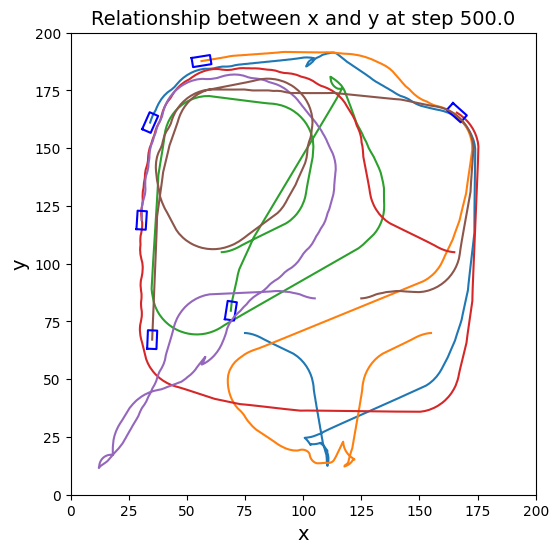

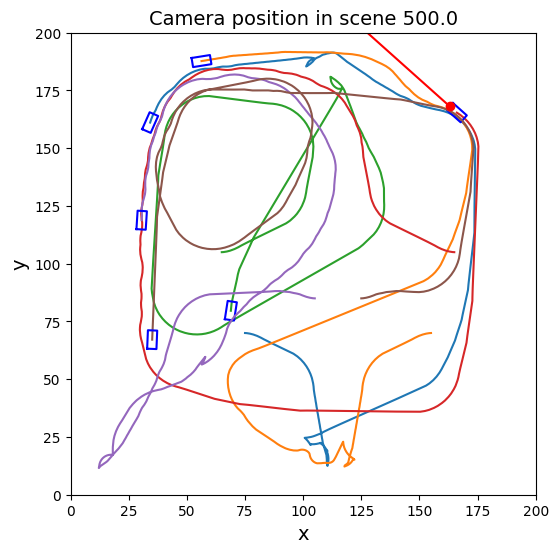

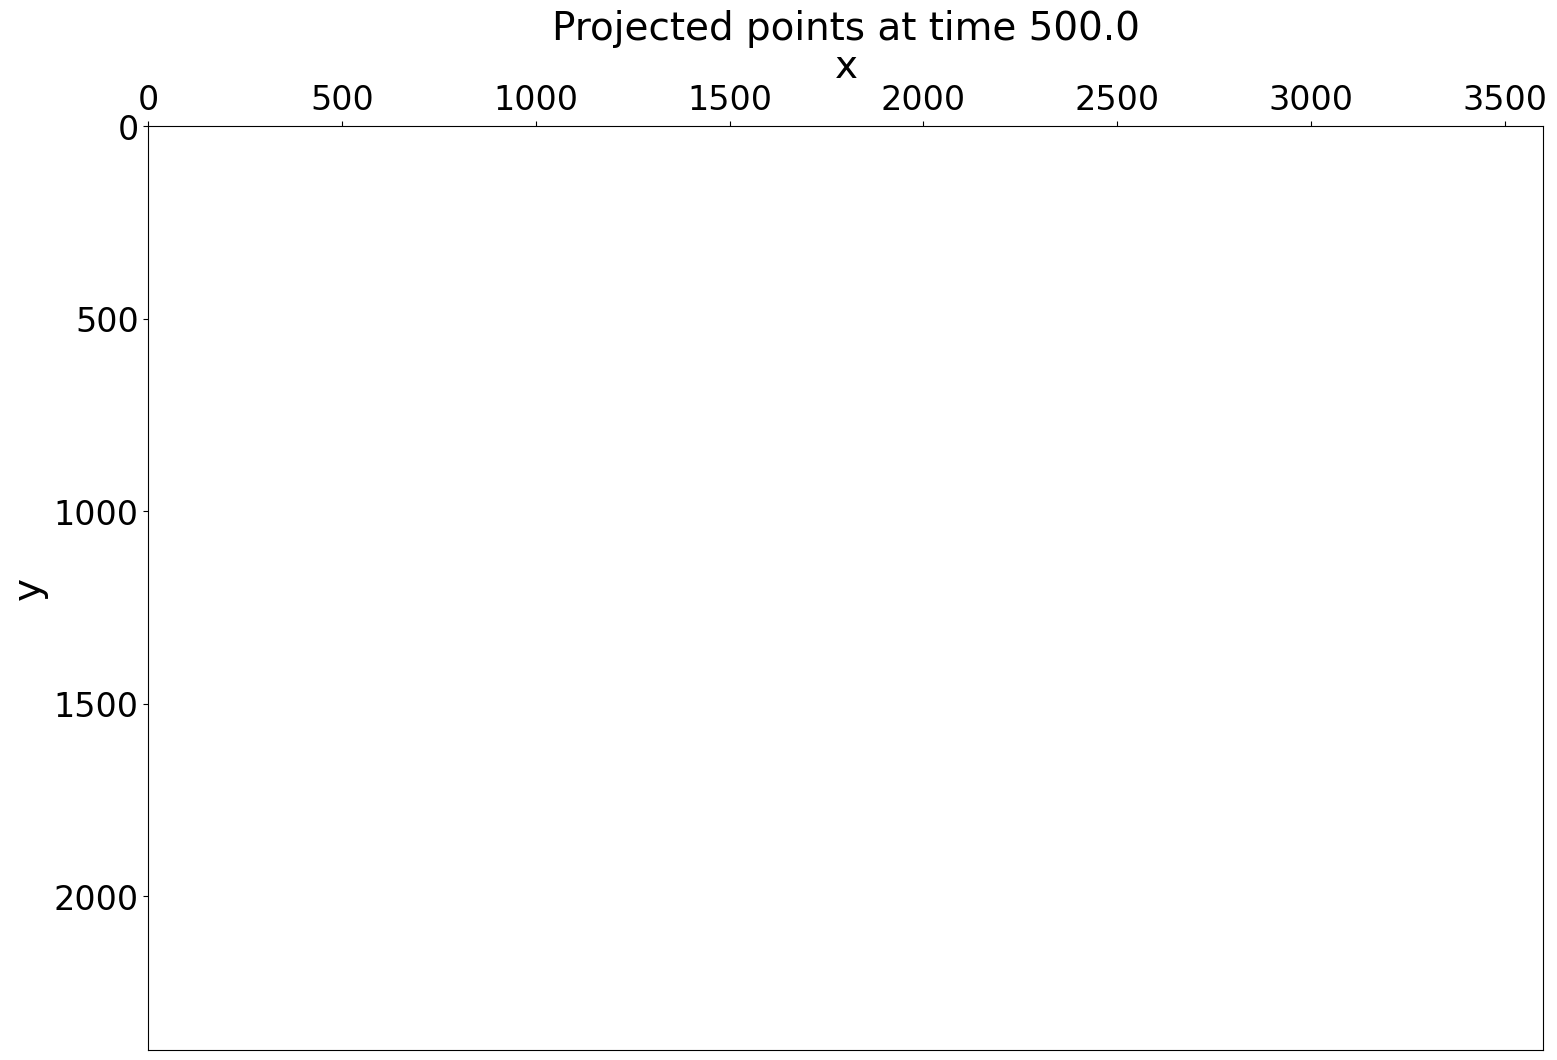

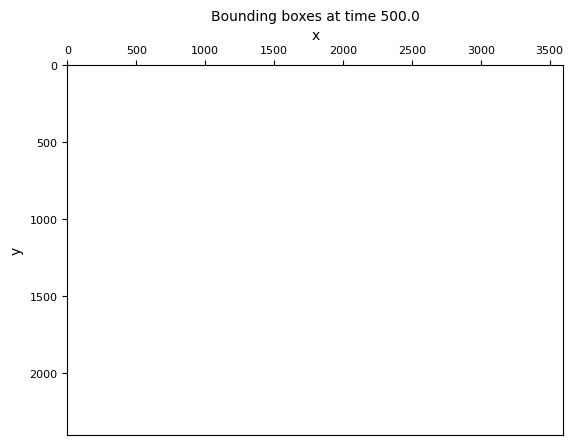

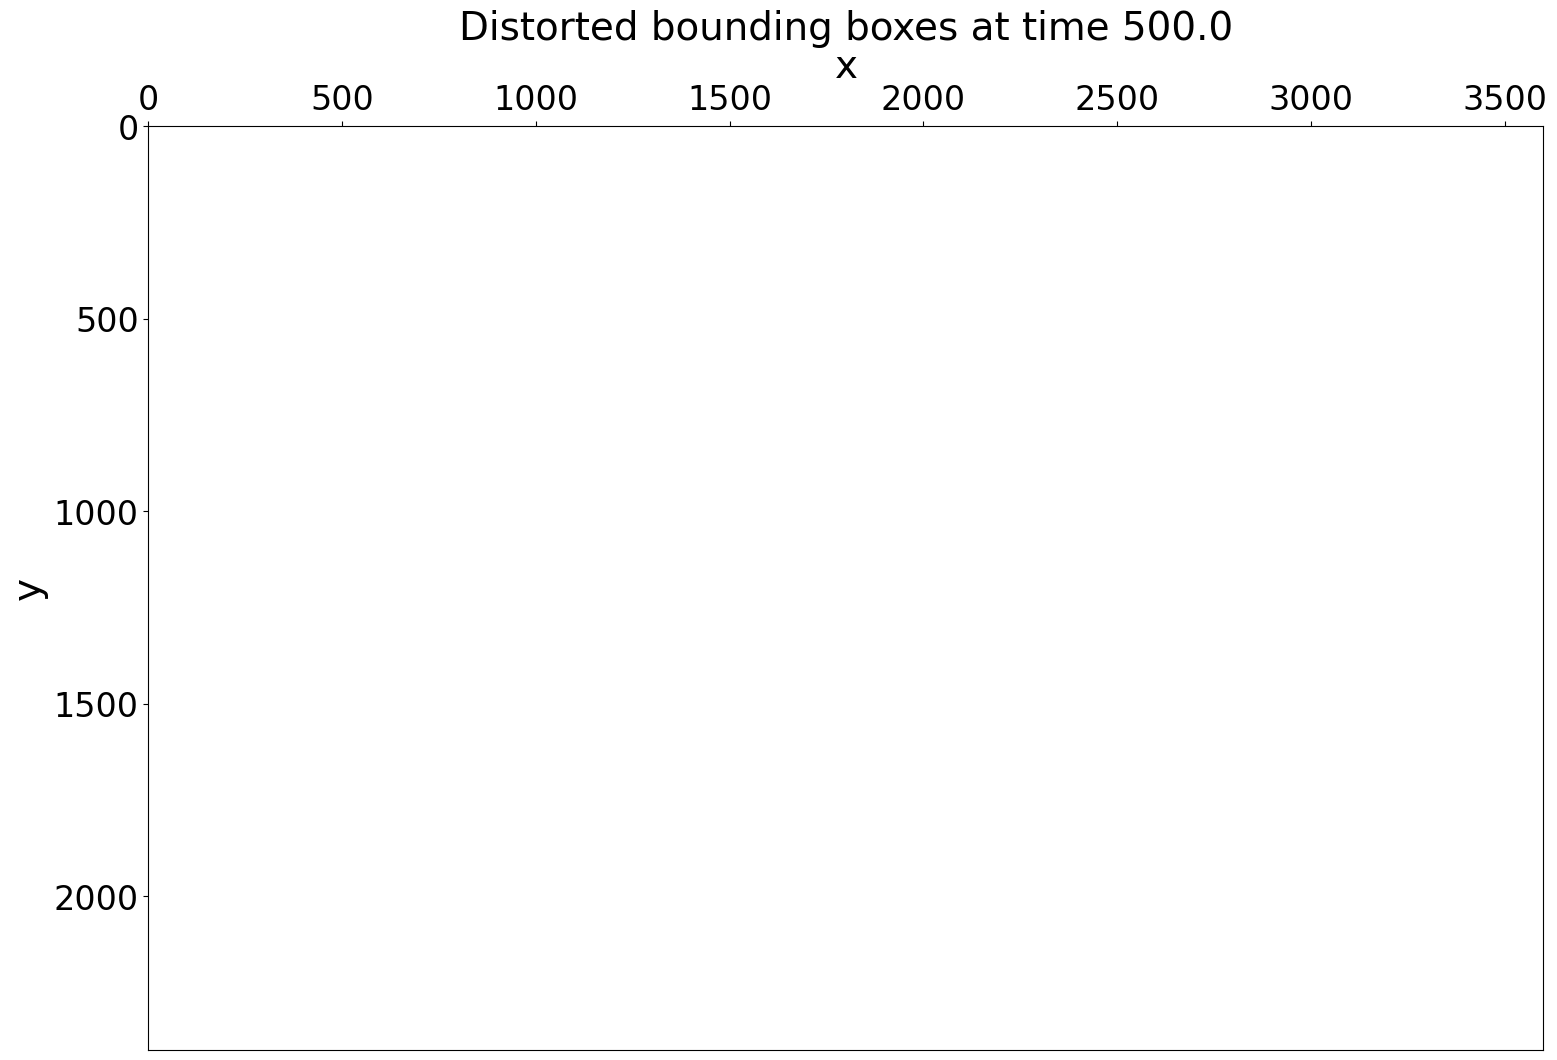

In [12]:
# Visualize from json files
if VISUALIZE:
    pps_path = os.path.join(simulation_folder, 'projectedPoints.json')
    bbs_path = os.path.join(simulation_folder, 'boundingBoxes.json')
    eBBs_path = os.path.join(simulation_folder, 'distortedBoundingBoxes.json')
    visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder, fps=3, skip=10, max_duration=5000, y_x_lim=200)
    visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder, fps=3, skip=10, max_duration=5000, y_x_lim=200)
    visualize_projections_json_mov(pps_path, camera_rig.camera.image_bounds, folder_path=simulation_folder, fps=3, skip=10, max_duration=5000)
    visualize_bounding_boxes_json_mov(bbs_path, camera_rig.camera.image_bounds, folder_path=simulation_folder, fps=3, skip=10, max_duration=5000)
    visualize_distorted_bounding_boxes_json_mov(eBBs_path, camera_rig.camera.image_bounds, show_original_BBS=True, original_BBs_path=bbs_path, folder_path=simulation_folder, fps=3, skip=10, max_duration=5000)

